In [1]:
# General libraries
from __future__ import print_function, division
import time
import os
import copy

# Camera
import cv2

# AI libraries
from facenet_pytorch import MTCNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# Math libraries
import numpy as np

# Image and visualisation Libraries
from PIL import Image
import matplotlib.pyplot as plt

# Show plots in the notbook
%matplotlib inline

In [2]:
# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on device "{device}"')

Running on device "cuda"


In [3]:
# Create model to detected faces
mtcnn = MTCNN(image_size=160, margin=0)

In [4]:
# Take image and store it under given path
# Define path
temp_path = "image.png"
# Open the camera
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
# Take picture
ret, frame = cap.read()
frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
cv2.imwrite(temp_path, frame)

# Close the cam
cap.release()
cv2.destroyAllWindows()

#get_path = cam.getImagesFromCamera()

# Get image
img = Image.open(temp_path)

# Save captured image for later output
img_raw = img

# Define a location for safing the image
save_name = "CURRENT"
save_path_crop = "Tryout/cropped_image/" + save_name + "_cropped.jpg"

# Create and save cropped image
# if probability is small, try to rotate the image and crop it again
img_crop_prob_list = list()
img_crop_prob = 0
n_rot = 0
angle_rot = 45
# check for best rotation to crop the image
for i in range(int(360/angle_rot)):
    # rotate image 
    img = img.rotate(angle_rot*n_rot)
    # Get cropped image and probability
    img_crop_all = mtcnn.forward(img, save_path=save_path_crop, return_prob=True)
    # Get image for later use
    img_crop = img_crop_all[0]
    # Get probability
    img_crop_prob = img_crop_all[1]
    # increase counter
    n_rot += 1
    if (img_crop_prob == None):
        img_crop_prob = 0
    img_crop_prob_list.append(img_crop_prob)
    
# Get best cropped image
# find best cropping based on highest probability
rot = img_crop_prob_list.index(max(img_crop_prob_list))
# take start image and rotate image 
img = img_raw.rotate(angle_rot*rot)
# Get cropped image and probability
img_crop_all = mtcnn.forward(img, save_path=save_path_crop, return_prob=True)
# Get image for later use
img_crop = img_crop_all[0]
# Get probability
img_crop_prob = img_crop_all[1]

/home/jan/anaconda3/envs/aibcva/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [5]:
# Define classes based on the exsisting data
classes = list()
# Get all labels from data folder
for name in os.listdir("Data/1_Data_Capture"):
    # Exclude hidden folders
    if not os.path.isdir(name):
        classes.append(name)
# Sort the classes in an alphabetical manner to get consistence between different scripts
classes.sort()

In [6]:
# load trained identification model
model_weights_path = "Model_Weights/resnet.pt"
resnet = models.resnet18().cuda()
# Add the last classification layer
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(classes))
# Load the trained weights
resnet.load_state_dict(torch.load(model_weights_path))
resnet.eval()
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Use network to process cropped image

preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Pass the image for preprocessing and the image preprocessed
img_preprocessed = preprocess(transforms.functional.adjust_brightness(Image.open(save_path_crop), 
                                                                      brightness_factor = 1)).to(device)
#img_preprocessed = preprocess(Image.open(jonghyun_path)).to(device)
# Reshape, crop, and normalize the input tensor for feeding into network for evaluation
out = resnet(torch.unsqueeze(img_preprocessed,0)).cpu().detach().numpy().flatten()
max_index = int(np.where(out == np.amax(out))[0])
label = classes[max_index]
print(max_index)

1


In [8]:
# calculate the softmax of a vector
def softmax(vector):
    e = np.exp(vector)
    return e / e.sum()

out_prob = softmax(out)
print(out_prob)

[0.10291775 0.8970822 ]


Captured image:


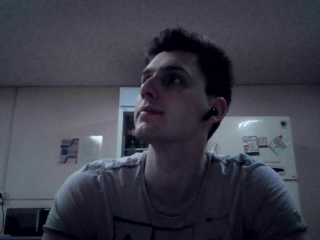

...Face detected and cropped with the probability  0.99852604

Cropped image


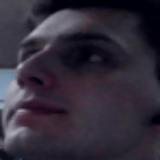

...Image labled with the label 'notJan' with probability 0.8970822


In [9]:
# Show the process of image processing
print("Captured image:")
display(img_raw)
# Show that image is cropped
print("...Face detected and cropped with the probability ", 
      str(img_crop_prob))
print("\nCropped image")
display(Image.open(save_path_crop))
print("...Image labled with the label '" + str(label) + "' with probability " + str(out_prob[max_index]))